<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import re

import sys
!{sys.executable} -m pip install unidecode --quiet
import unidecode

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset chistes en español

In [2]:
#Carga de datos
with open('/content/chistes.txt', 'r') as file:
  raw_chistes = file.read()

In [3]:
# Limpieza de caracteres especiales
chistes = unidecode.unidecode(raw_chistes)
chistes = re.sub(r'[^a-zA-Z0-9_ ñ.\s]', '', chistes)
chistes = re.sub(r'\.+', ' ', chistes)
chistes = re.sub(r'\ +', ' ', chistes)
chistes = chistes.lower()
chistes =  chistes.split('\n')

In [4]:
len(chistes)

631

In [5]:
chistes[0]

'primera escena un hipopotamo pequeno segunda escena un hipopotamo mediano tercera escena un hipopotamo grande titulo de la obra hipocrecia'

In [6]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.DataFrame(chistes)
df.head()

,0
0,primera escena un hipopotamo pequeno segunda e...
1,tienes wifi si y cual es la clave tener diner...
2,en una entrevista de trabajo nivel de ingles a...
3,cual es el cafe mas peligroso del mundoel expreso
4,mama mama los spaghetti se estan pegando deja...


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 631


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [8]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [9]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[1,0]
text

' tienes wifi si y cual es la clave tener dinero y pagarlo '

In [10]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['tienes',
 'wifi',
 'si',
 'y',
 'cual',
 'es',
 'la',
 'clave',
 'tener',
 'dinero',
 'y',
 'pagarlo']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [11]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [12]:
# Demos un vistazo
sentence_tokens[:2]

[['primera',
  'escena',
  'un',
  'hipopotamo',
  'pequeno',
  'segunda',
  'escena',
  'un',
  'hipopotamo',
  'mediano',
  'tercera',
  'escena',
  'un',
  'hipopotamo',
  'grande',
  'titulo',
  'de',
  'la',
  'obra',
  'hipocrecia'],
 ['tienes',
  'wifi',
  'si',
  'y',
  'cual',
  'es',
  'la',
  'clave',
  'tener',
  'dinero',
  'y',
  'pagarlo']]

In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['tienes', 'wifi', 'si', 'y'],
 ['wifi', 'si', 'y', 'cual'],
 ['si', 'y', 'cual', 'es'],
 ['y', 'cual', 'es', 'la'],
 ['cual', 'es', 'la', 'clave'],
 ['es', 'la', 'clave', 'tener'],
 ['la', 'clave', 'tener', 'dinero'],
 ['clave', 'tener', 'dinero', 'y'],
 ['tener', 'dinero', 'y', 'pagarlo']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [15]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[10, 9, 7, 1],
 [9, 7, 1, 2],
 [7, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 8],
 [5, 6, 8, 1],
 [6, 8, 1, 11]]

In [17]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

9


In [18]:
# Cantidad de veces que aparece cada palabra
print(tok.word_counts)

OrderedDict([('tienes', 1), ('wifi', 2), ('si', 3), ('y', 6), ('cual', 4), ('es', 4), ('la', 4), ('clave', 4), ('tener', 4), ('dinero', 3), ('pagarlo', 1)])


In [19]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'y': 1, 'cual': 2, 'es': 3, 'la': 4, 'clave': 5, 'tener': 6, 'si': 7, 'dinero': 8, 'wifi': 9, 'tienes': 10, 'pagarlo': 11}


In [20]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'si': 3, 'tienes': 1, 'y': 6, 'wifi': 2, 'cual': 4, 'es': 4, 'la': 4, 'clave': 4, 'tener': 4, 'dinero': 3, 'pagarlo': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior.
En este caso no unimos a texto completo ya que al tratarse de chistes individuales, no tendría sentido continuar uno con el otro.

In [21]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     primera escena un hipopotamo pequeno segunda e...
1      tienes wifi si y cual es la clave tener diner...
2     en una entrevista de trabajo nivel de ingles a...
3     cual es el cafe mas peligroso del mundoel expreso
4      mama mama los spaghetti se estan pegando deja...
5           soy rosa ah perdoname es que soy daltonico 
6      oye cual es tu plato favorito y por que pues ...
7               que pasa si tiras un pato al agua nada 
8      ayer llame a la policia porque unos ladrones ...
9               como te llamas lancelot pues atrapalot 
10     papa que esta mas lejos cordoba o la luna per...
11     mi ordenador me gana al ajedrez pero yo le ga...
12     general soldado ice la banderasoldado pues le...
13     a las 10 te pito y bajas te has comprado un c...
14     cual es el coche favorito de un fotografoel f...
15     oye cuanto te costo esa terapia que hiciste p...
Name: 0, dtype: object

In [22]:
# Creamos vectores separando los chistes individualmente antes de tokenizar
for j in range(len(df)):
  tokens= text_to_word_sequence( str(df.loc[j][0]))
  for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

In [23]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['tienes', 'wifi', 'si', 'y'],
 ['wifi', 'si', 'y', 'cual'],
 ['si', 'y', 'cual', 'es'],
 ['y', 'cual', 'es', 'la'],
 ['cual', 'es', 'la', 'clave'],
 ['es', 'la', 'clave', 'tener'],
 ['la', 'clave', 'tener', 'dinero'],
 ['clave', 'tener', 'dinero', 'y'],
 ['tener', 'dinero', 'y', 'pagarlo'],
 ['primera', 'escena', 'un', 'hipopotamo'],
 ['escena', 'un', 'hipopotamo', 'pequeno'],
 ['un', 'hipopotamo', 'pequeno', 'segunda'],
 ['hipopotamo', 'pequeno', 'segunda', 'escena'],
 ['pequeno', 'segunda', 'escena', 'un'],
 ['segunda', 'escena', 'un', 'hipopotamo'],
 ['escena', 'un', 'hipopotamo', 'mediano'],
 ['un', 'hipopotamo', 'mediano', 'tercera'],
 ['hipopotamo', 'mediano', 'tercera', 'escena'],
 ['mediano', 'tercera', 'escena', 'un'],
 ['tercera', 'escena', 'un', 'hipopotamo']]

In [24]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[158, 874, 19, 7],
 [874, 19, 7, 75],
 [19, 7, 75, 13],
 [7, 75, 13, 4],
 [75, 13, 4, 496],
 [13, 4, 496, 100],
 [4, 496, 100, 193],
 [496, 100, 193, 7],
 [100, 193, 7, 2310],
 [205, 442, 6, 333],
 [442, 6, 333, 250],
 [6, 333, 250, 497],
 [333, 250, 497, 442],
 [250, 497, 442, 6],
 [497, 442, 6, 333],
 [442, 6, 333, 875],
 [6, 333, 875, 876],
 [333, 875, 876, 442],
 [875, 876, 442, 6],
 [876, 442, 6, 333]]

### 3 - Input y target

In [25]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])

print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [26]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [27]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(9602, 3)
(9602,)


In [28]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'a',
 3: 'de',
 4: 'la',
 5: 'el',
 6: 'un',
 7: 'y',
 8: 'no',
 9: 'en',
 10: 'se',
 11: 'le',
 12: 'una',
 13: 'es',
 14: 'dice',
 15: 'los',
 16: 'me',
 17: 'por',
 18: 'con',
 19: 'si',
 20: 'tan',
 21: 'pero',
 22: 'mama',
 23: 'al',
 24: 'su',
 25: 'lo',
 26: 'porque',
 27: 'te',
 28: 'pues',
 29: 'para',
 30: 'tu',
 31: 'mi',
 32: 'hombre',
 33: 'las',
 34: 'como',
 35: 'jaimito',
 36: 'esta',
 37: 'ya',
 38: 'mujer',
 39: 'cuando',
 40: 'otro',
 41: 'hijo',
 42: 'pregunta',
 43: 'ha',
 44: 'del',
 45: 'mas',
 46: 'papa',
 47: 'yo',
 48: 'eso',
 49: 'va',
 50: 'lepe',
 51: 'dos',
 52: 'padre',
 53: 'he',
 54: 'uno',
 55: 'responde',
 56: 'hacer',
 57: 'hace',
 58: 'doctor',
 59: 'tiene',
 60: 'nino',
 61: 'contesta',
 62: 'otra',
 63: 'bien',
 64: 'ver',
 65: 'senor',
 66: 'donde',
 67: 'madre',
 68: 'vez',
 69: 'solo',
 70: 'tengo',
 71: 'quiero',
 72: 'estan',
 73: 'hombres',
 74: 'dijo',
 75: 'cual',
 76: 'hay',
 77: 'usted',
 78: 'parecen',
 79: 'ser',
 80: 'p

In [29]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2415

In [30]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(9602, 2415)

### 4 - Entrenar el modelo

In [31]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [32]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2415

In [37]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 2415 palabras distintas
# output_dim = 3 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=input_seq_len))


model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 50)             120800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 64)             29440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 64)            

In [38]:
hist = model.fit(x_data, y_data, epochs=100,batch_size=8, validation_split=0.2)

Epoch 1/100
961/961 [==============================] - 22s 17ms/step - loss: 6.5873 - accuracy: 0.0417 - val_loss: 6.4531 - val_accuracy: 0.0547
Epoch 2/100
961/961 [==============================] - 15s 15ms/step - loss: 6.1369 - accuracy: 0.0430 - val_loss: 6.6159 - val_accuracy: 0.0547
Epoch 3/100
961/961 [==============================] - 15s 15ms/step - loss: 6.0425 - accuracy: 0.0418 - val_loss: 6.6992 - val_accuracy: 0.0541
Epoch 4/100
961/961 [==============================] - 15s 15ms/step - loss: 5.9501 - accuracy: 0.0449 - val_loss: 6.9445 - val_accuracy: 0.0547
Epoch 5/100
961/961 [==============================] - 15s 15ms/step - loss: 5.8425 - accuracy: 0.0441 - val_loss: 6.8150 - val_accuracy: 0.0567
Epoch 6/100
961/961 [==============================] - 15s 15ms/step - loss: 5.6690 - accuracy: 0.0465 - val_loss: 6.8146 - val_accuracy: 0.0521
Epoch 7/100
961/961 [==============================] - 15s 15ms/step - loss: 5.4912 - accuracy: 0.0543 - val_loss: 6.8398 - val_ac

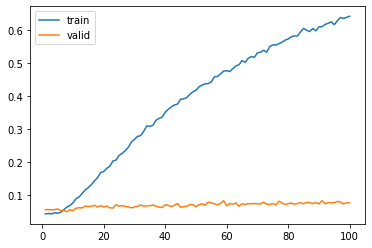

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Se observa la presencia de overfitting. El dataset no es suficiente para evitarlo. Entrenamos por 100 epochs mas

In [48]:
hist = model.fit(x_data, y_data, epochs=100,batch_size=8)

Epoch 1/100
1201/1201 [==============================] - 17s 14ms/step - loss: 4.3579 - accuracy: 0.3853
Epoch 2/100
1201/1201 [==============================] - 17s 14ms/step - loss: 3.3491 - accuracy: 0.4131
Epoch 3/100
1201/1201 [==============================] - 17s 14ms/step - loss: 3.0425 - accuracy: 0.4274
Epoch 4/100
1201/1201 [==============================] - 16s 14ms/step - loss: 2.8484 - accuracy: 0.4367
Epoch 5/100
1201/1201 [==============================] - 17s 14ms/step - loss: 2.6733 - accuracy: 0.4504
Epoch 6/100
1201/1201 [==============================] - 17s 14ms/step - loss: 2.5429 - accuracy: 0.4561
Epoch 7/100
1201/1201 [==============================] - 17s 14ms/step - loss: 2.4243 - accuracy: 0.4693
Epoch 8/100
1201/1201 [==============================] - 16s 14ms/step - loss: 2.3159 - accuracy: 0.4796
Epoch 9/100
1201/1201 [==============================] - 16s 14ms/step - loss: 2.2085 - accuracy: 0.4922
Epoch 10/100
1201/1201 [==============================]

### 5 - Predicción de próxima palabra

In [40]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [41]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 206 kB 48.6 MB/s 
     |████████████████████████████████| 1.9 MB 43.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 3.0 MB 39.3 MB/s 
     |████████████████████████████████| 961 kB 44.4 MB/s 


In [42]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://39021.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

### 6 - Generación de secuencias nuevas

In [49]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [50]:
input_text='que le dice'

generate_seq(model, tok, input_text, max_length=3, n_words=20)

'que le dice el calzoncillos que 7 principe por a criatura te hijo hace dice me primo colegio a gato al obsesionado me'

In [54]:
input_text='primer acto'

generate_seq(model, tok, input_text, max_length=3, n_words=20)

'primer acto como supervision cien euros beber se quieres ayuda que dice que dos solo una nacemos en frente por la zapatos'

Vemos que la cantidad de capas y el dataset no es suficiente para este caso

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.